Method 1: SMOTE

In [1]:
import os
import sys
sys.path.append("./../src/")
from utilities import REPO_PATH, DATA_PATH, RESPONSE_COL_NAME, get_feature_corr_with_response

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
seed = 0
random.seed(seed)

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score

In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import torch.nn.init as init
from torch.utils.data import Dataset

In [4]:
train = pd.read_csv(f"{DATA_PATH}/train.csv")
test = pd.read_csv(f"{DATA_PATH}/test.csv")
val = pd.read_csv(f"{DATA_PATH}/val.csv")

In [5]:
X_train, y_train = train.drop([RESPONSE_COL_NAME], axis=1), train[RESPONSE_COL_NAME]
y_test, X_test = test[RESPONSE_COL_NAME], test.drop([RESPONSE_COL_NAME],axis=1)

In [7]:
beforeCounter = Counter(y_train)
print("Before:", beforeCounter)

Before: Counter({True: 17000, False: 424})


In [8]:
sample_ratios = np.arange(0.1,1.1,0.1)

In [9]:
accuracy_scores_by_ratio = []
for ratio in sample_ratios:
    smt = SMOTE(sampling_strategy=ratio)
    X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
    afterCounter = Counter(y_train_sm)
    print("After:", afterCounter)

    clf = BernoulliNB()
    clf.fit(X_train_sm, y_train_sm)
    y_preds = clf.predict(X_test)
    accuracy = accuracy_score(y_preds, y_test)
    accuracy_scores_by_ratio.append(accuracy)
    print("Accuracy:", accuracy)
    print(" ")
    

After: Counter({True: 17000, False: 1700})
Accuracy: 0.6535714285714286
 
After: Counter({True: 17000, False: 3400})
Accuracy: 0.6642857142857143
 
After: Counter({True: 17000, False: 5100})
Accuracy: 0.675
 
After: Counter({True: 17000, False: 6800})
Accuracy: 0.6785714285714286
 
After: Counter({True: 17000, False: 8500})
Accuracy: 0.6821428571428572
 
After: Counter({True: 17000, False: 10200})
Accuracy: 0.6821428571428572
 
After: Counter({True: 17000, False: 11900})
Accuracy: 0.6785714285714286
 
After: Counter({True: 17000, False: 13600})
Accuracy: 0.6785714285714286
 
After: Counter({True: 17000, False: 15300})
Accuracy: 0.6892857142857143
 
After: Counter({False: 17000, True: 17000})
Accuracy: 0.6857142857142857
 


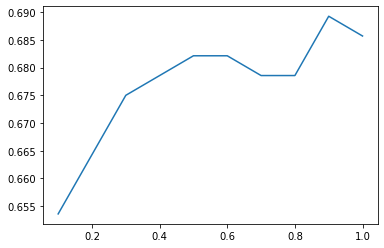

In [10]:
plt.plot(sample_ratios, accuracy_scores_by_ratio)
plt.show()

Building a GAN to generate Synthetic Data

In [6]:
class Data(Dataset):
    def __init__(self, X, y):
        self.data = X.values.astype(np.float32)
        self.labels = y.values.astype(np.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        sample = {
            'input': torch.tensor(self.data[idx]),
            'label': torch.tensor(self.labels[idx])
        }
        return sample

In [7]:
# Generation Block Function
def FC_Layer_blockGen(input_dim, output_dim):
    single_block = nn.Sequential(
        nn.Linear(input_dim, output_dim),

        nn.ReLU()
    )
    return single_block

# Discriminattor Block Function   
def FC_Layer_BlockDisc(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.ReLU(),
        nn.Dropout(0.4)
    )

In [8]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
            nn.Tanh()  
        )

    def forward(self, x):
        return self.model(x)
    
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [9]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)

In [10]:
#Define training parameters
batch_size = 256
num_epochs = 50
lr = 0.0002
num_features = 62
latent_dim = 20

In [11]:
# Define data dimensions
noise_dim = 20

In [12]:
# MODEL INITIALIZATION
generator = Generator(noise_dim, num_features)
discriminator = Discriminator(num_features)

# LOSS FUNCTION AND OPTIMIZERS
criterion = nn.BCELoss()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [13]:
dataset = Data(X_train,y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [14]:
generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)

In [15]:

latent_dim =20
for epoch in range(num_epochs):
    for batch in dataloader:
        real_data_batch = batch['input']
        # Train discriminator on real data
        real_labels = batch['label']
        disc_optimizer.zero_grad()
        output_real = discriminator(real_data_batch).reshape(256)
        loss_real = criterion(output_real, real_labels)
        loss_real.backward()

        # Train discriminator on generated data
        fake_labels = torch.FloatTensor(np.random.uniform(0, 0.1, (batch_size, 1)))
        noise = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))
        generated_data = generator(noise)
        output_fake = discriminator(generated_data.detach())
        loss_fake = criterion(output_fake, fake_labels)
        loss_fake.backward()

        disc_optimizer.step()

        # Train generator 
        valid_labels = torch.FloatTensor(np.random.uniform(0.9, 1.0, (batch_size, 1)))
        gen_optimizer.zero_grad()
        output_g = discriminator(generated_data)
        loss_g = criterion(output_g, valid_labels)
        loss_g.backward()
        gen_optimizer.step()

    # Print progress
    print(f"Epoch {epoch}, D Loss Real: {loss_real.item()}, D Loss Fake: {loss_fake.item()}, G Loss: {loss_g.item()}")

Epoch 0, D Loss Real: 97.265625, D Loss Fake: 0.19839943945407867, G Loss: 3.2098233699798584
Epoch 1, D Loss Real: 97.265625, D Loss Fake: 0.19797861576080322, G Loss: 2.8143837451934814
Epoch 2, D Loss Real: 96.875, D Loss Fake: 0.2079828679561615, G Loss: 2.8479833602905273
Epoch 3, D Loss Real: 98.4375, D Loss Fake: 0.20768502354621887, G Loss: 2.871220588684082
Epoch 4, D Loss Real: 95.703125, D Loss Fake: 0.21285679936408997, G Loss: 2.8376951217651367
Epoch 5, D Loss Real: 97.65625, D Loss Fake: 0.20515671372413635, G Loss: 2.8934011459350586
Epoch 6, D Loss Real: 98.046875, D Loss Fake: 0.19244825839996338, G Loss: 2.7916908264160156
Epoch 7, D Loss Real: 96.875, D Loss Fake: 0.20365092158317566, G Loss: 2.865896701812744
Epoch 8, D Loss Real: 98.4375, D Loss Fake: 0.19679862260818481, G Loss: 2.8690593242645264
Epoch 9, D Loss Real: 96.484375, D Loss Fake: 0.19793488085269928, G Loss: 2.839559555053711
Epoch 10, D Loss Real: 97.265625, D Loss Fake: 0.19665932655334473, G Loss:

In [ ]:
synthetic_data = generator(torch.FloatTensor(np.random.normal(0, 1, (17280-704, noise_dim))))
#synthetic_data = [x.detach() for x in synthetic_data]

In [ ]:
synthetic_data.shape

NameError: name 'synthetic_data' is not defined